In [1]:
import pandas as pd
import seaborn as sns
from __future__ import print_function
from collections import Counter
import numpy as np 

# the below code is to build the decision tree algorithm

In [16]:
class Node: 
    
    def __init__(
        self, 
        Y: list,
        X: pd.DataFrame,
        min_samples_split=None,
        max_depth=None,
        depth=None,
        node_type=None,
        rule=None
    ):
        
        self.Y = Y 
        self.X = X

       
        self.min_samples_split = min_samples_split if min_samples_split else 20
        self.max_depth = max_depth if max_depth else 5

        
        self.depth = depth if depth else 0

       
        self.features = list(self.X.columns)

      
        self.node_type = node_type if node_type else 'root'

      
        self.rule = rule if rule else ""

        
        self.counts = Counter(Y)

        
        self.gini_impurity = self.get_GINI()

        
        counts_sorted = list(sorted(self.counts.items(), key=lambda item: item[1]))

        
        yhat = None
        if len(counts_sorted) > 0:
            yhat = counts_sorted[-1][0]

        
        self.yhat = yhat 

        
        self.n = len(Y)

        
        self.left = None 
        self.right = None 

        
        self.best_feature = None 
        self.best_value = None 

    @staticmethod
    def GINI_impurity(y1_count: int, y2_count: int) -> float:
       
        
        if y1_count is None:
            y1_count = 0

        if y2_count is None:
            y2_count = 0

        
        n = y1_count + y2_count
        
        
        if n == 0:
            return 0.0

        
        p1 = y1_count / n
        p2 = y2_count / n
        
        
        gini = 1 - (p1 ** 2 + p2 ** 2)
        
        
        return gini

    @staticmethod
    def ma(x: np.array, window: int) -> np.array:
        
        return np.convolve(x, np.ones(window), 'valid') / window

    def get_GINI(self):
        
        y1_count, y2_count = self.counts.get(0, 0), self.counts.get(1, 0)

        
        return self.GINI_impurity(y1_count, y2_count)

    def best_split(self) -> tuple:
     
        
        df = self.X.copy()
        df['Y'] = self.Y

         
        GINI_base = self.get_GINI()

        
        max_gain = 0

        
        best_feature = None
        best_value = None

        for feature in self.features:
            
            Xdf = df.dropna().sort_values(feature)

            
            xmeans = self.ma(Xdf[feature].unique(), 2)

            for value in xmeans:
                 
                left_counts = Counter(Xdf[Xdf[feature]<value]['Y'])
                right_counts = Counter(Xdf[Xdf[feature]>=value]['Y'])

                
                y0_left, y1_left, y0_right, y1_right = left_counts.get(0, 0), left_counts.get(1, 0), right_counts.get(0, 0), right_counts.get(1, 0)

               
                gini_left = self.GINI_impurity(y0_left, y1_left)
                gini_right = self.GINI_impurity(y0_right, y1_right)

                
                n_left = y0_left + y1_left
                n_right = y0_right + y1_right

                
                w_left = n_left / (n_left + n_right)
                w_right = n_right / (n_left + n_right)

                
                wGINI = w_left * gini_left + w_right * gini_right

                 
                GINIgain = GINI_base - wGINI

                
                if GINIgain > max_gain:
                    best_feature = feature
                    best_value = value 

                    
                    max_gain = GINIgain

        return (best_feature, best_value)

    def grow_tree(self):
        
        df = self.X.copy()
        df['Y'] = self.Y

         
        if (self.depth < self.max_depth) and (self.n >= self.min_samples_split):

            
            best_feature, best_value = self.best_split()

            if best_feature is not None:
                
                self.best_feature = best_feature
                self.best_value = best_value

                
                left_df, right_df = df[df[best_feature]<=best_value].copy(), df[df[best_feature]>best_value].copy()

               
                left = Node(
                    left_df['Y'].values.tolist(), 
                    left_df[self.features], 
                    depth=self.depth + 1, 
                    max_depth=self.max_depth, 
                    min_samples_split=self.min_samples_split, 
                    node_type='left_node',
                    rule=f"{best_feature} <= {round(best_value, 3)}"
                    )

                self.left = left 
                self.left.grow_tree()

                right = Node(
                    right_df['Y'].values.tolist(), 
                    right_df[self.features], 
                    depth=self.depth + 1, 
                    max_depth=self.max_depth, 
                    min_samples_split=self.min_samples_split,
                    node_type='right_node',
                    rule=f"{best_feature} > {round(best_value, 3)}"
                    )

                self.right = right
                self.right.grow_tree()

    def print_info(self, width=4):
       
        
        const = int(self.depth * width ** 1.5)
        spaces = "-" * const
        
        if self.node_type == 'root':
            print("Root")
        else:
            print(f"|{spaces} Split rule: {self.rule}")
        print(f"{' ' * const}   | GINI impurity of the node: {round(self.gini_impurity, 2)}")
        print(f"{' ' * const}   | Class distribution in the node: {dict(self.counts)}")
        print(f"{' ' * const}   | Predicted class: {self.yhat}")   

    def print_tree(self):
       
        self.print_info() 
        
        if self.left is not None: 
            self.left.print_tree()
        
        if self.right is not None:
            self.right.print_tree()

    def predict(self, X:pd.DataFrame):
      
        predictions = []

        for _, x in X.iterrows():
            values = {}
            for feature in self.features:
                values.update({feature: x[feature]})
        
            predictions.append(self.predict_obs(values))
        
        return predictions

    def predict_obs(self, values: dict) -> int:
       
        cur_node = self
        while cur_node.depth < cur_node.max_depth:
            
            best_feature = cur_node.best_feature
            best_value = cur_node.best_value

            if cur_node.n < cur_node.min_samples_split:
                break 

            if (values.get(best_feature) < best_value):
                if self.left is not None:
                    cur_node = cur_node.left
            else:
                if self.right is not None:
                    cur_node = cur_node.right
            
        return cur_node.yhat

# The code below is to import the csv dataset and deal with the missing values by removing it

In [17]:
dataset = pd.read_csv("stroke.csv")
dataset.replace([np.inf, -np.inf], np.nan, inplace=True)
dataset.fillna(999, inplace=True)


<AxesSubplot:>

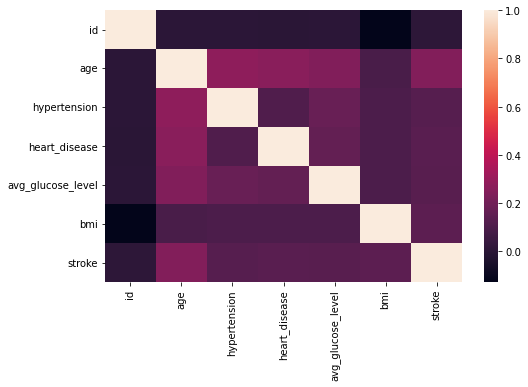

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(8,5))
sns.heatmap(dataset.corr())



In [19]:
dataset.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,999.0,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [20]:
for x in ['bmi']:
    q75,q25 = np.percentile(dataset.loc[:,x],[75,25])
    intr_qr = q75-q25
 
    max = q75+(1.5*intr_qr)
    min = q25-(1.5*intr_qr)
 
    dataset.loc[dataset[x] < min,x] = np.nan
    dataset.loc[dataset[x] > max,x] = np.nan

# The code below specifies the atributes needed to classfy


In [21]:
x = dataset.iloc[:,1:10]

# This code below changes the string values to 0 and 1


In [22]:
x= pd.get_dummies(x)

# This code below is for the class atribute 

In [23]:
y = dataset.iloc[:,-1].values

In [24]:
x

,age,hypertension,heart_disease,avg_glucose_level,bmi,gender_Female,gender_Male,gender_Other,ever_married_No,ever_married_Yes,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban
0,67.0,0,1,228.69,36.6,0,1,0,0,1,0,0,1,0,0,0,1
1,61.0,0,0,202.21,NaN,1,0,0,0,1,0,0,0,1,0,1,0
2,80.0,0,1,105.92,32.5,0,1,0,0,1,0,0,1,0,0,1,0
3,49.0,0,0,171.23,34.4,1,0,0,0,1,0,0,1,0,0,0,1
4,79.0,1,0,174.12,24.0,1,0,0,0,1,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5105,80.0,1,0,83.75,NaN,1,0,0,0,1,0,0,1,0,0,0,1
5106,81.0,0,0,125.20,40.0,1,0,0,0,1,0,0,0,1,0,0,1
5107,35.0,0,0,82.99,30.6,1,0,0,0,1,0,0,0,1,0,1,0
5108,51.0,0,0,166.29,25.6,0,1,0,0,1,0,0,1,0,0,1,0


In [25]:
from sklearn.model_selection import train_test_split

In [26]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.20, random_state=42)

In [27]:

root = Node(y_train, x_train, max_depth=3, min_samples_split=100)

In [28]:
root.grow_tree()


In [29]:
root.print_tree()


Root
   | GINI impurity of the node: 0.09
   | Class distribution in the node: {0: 3901, 1: 187}
   | Predicted class: 0
|-------- Split rule: age <= 67.5
           | GINI impurity of the node: 0.04
           | Class distribution in the node: {0: 3322, 1: 74}
           | Predicted class: 0
|---------------- Split rule: age <= 47.5
                   | GINI impurity of the node: 0.01
                   | Class distribution in the node: {0: 2200, 1: 11}
                   | Predicted class: 0
|------------------------ Split rule: avg_glucose_level <= 58.115
                           | GINI impurity of the node: 0.06
                           | Class distribution in the node: {0: 61, 1: 2}
                           | Predicted class: 0
|------------------------ Split rule: avg_glucose_level > 58.115
                           | GINI impurity of the node: 0.01
                           | Class distribution in the node: {0: 2139, 1: 9}
                           | Predicted class: 0


# the code below is to predict

In [30]:
Y_p = root.predict(x_test)

In [31]:
from sklearn.metrics import classification_report, confusion_matrix

In [32]:
print(classification_report(y_test, Y_p))

              precision    recall  f1-score   support

           0       0.94      0.99      0.97       960
           1       0.42      0.08      0.14        62

    accuracy                           0.94      1022
   macro avg       0.68      0.54      0.55      1022
weighted avg       0.91      0.94      0.92      1022



# the above info tells us that the accuracy of 94% and f1-score of 97% and recall of 100% precision of 94%